# Code for sparse coding of spectrotemporal data
*Nhat Le, Sep 2017*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
import skimage.io
from sklearn.decomposition import PCA
import skimage.filters
import skimage.morphology
import seaborn as sns
import os.path
import pandas as pd
import pickle

%matplotlib inline

## Core functions for updating s and A

In [3]:
def T(u, lamb, norm_type):
    '''Threshold function with the appropriate norm type (L0 or L1)'''
    if norm_type == 'L0':
        return max(u, 0.0)
    elif norm_type == 'L1':
        return max(u - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')

# Vectorized version of T        
T_vec = np.vectorize(T)
    
def find_s(tau, A, y, lamb, niter=100, update='paper', verbose=False):
    '''Perform LCA to find the sparse representation s, given a dictionary
    of features, A, and target y. Returns optimal s, and best cost.
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    y = y[:, np.newaxis]
    s = np.zeros((A.shape[1], 1), dtype='float')
    best_s = np.zeros((A.shape[1], 1), dtype='float')
    u = np.zeros((A.shape[1], 1), dtype='float')
    
    # Start competition
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            s += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            
            u += du * tau
            print(u)
            s = T_vec(u, lamb, norm_type='L1')
            print(s)
            
        cost = 0.5 * np.linalg.norm(y - np.dot(A, s))**2 + lamb * np.linalg.norm(s, ord=1)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_s = s
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost, 'Best s =', best_s.T)
    return best_s, best_cost


def find_s_batch(tau, A, Y, lamb, niter=100, update='paper', verbose=False):
    '''Find s for each target, given a collection of targets Y.
    Returns a matrix S: n_neurons x n_targets, and the best cost
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    best_cost = np.inf
    cost_prev = np.inf
    S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    best_S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    U = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            S += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            
            U += du * tau
            
            S = T_vec(U, lamb, norm_type='L1')
            
        diff = (Y - np.dot(A, S)).ravel()
        cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(S.ravel(), ord=1)
        #print('cost: ', cost)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_S = S
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost)
    return best_S, best_cost

In [4]:
def learn_step(y, A, s, eta, theta):
    '''Update the dictionary A of receptive fields, given the vector s 
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    s = s[:, np.newaxis]
    y = y[:, np.newaxis]
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def learn_step_batch(Y, A, S, eta, theta):
    '''Update the dictionary A of receptive fields, given the matrix S of all activity vectors,
    and Y, a matrix containing all the training examples.
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    R = Y - np.dot(A, S)
    A_new = A + eta * (np.dot(R, S.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def do_multiple_learn_steps(y, A, s, eta, theta, nsteps=10, verbose=False):
    '''Perform multiple steps of learning A
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    diff = (y - np.dot(A, s)).ravel()
    cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
    prev_cost = cost
    best_cost = cost
    A_best = A
    for i in range(nsteps):
        #from IPython.core.debugger import Tracer; Tracer()() 
        if y.ndim == 1: # Single example
            A = learn_step(y, A, s, eta, theta)
            cost = np.linalg.norm(y - np.dot(A, s))**2
        else: # batch
            assert(y.shape[1] == s.shape[1])
            A = learn_step_batch(y, A, s, eta, theta)
            diff = (y - np.dot(A, s)).ravel()
            cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
            #cost = np.linalg.norm(y - np.dot(A, s))**2
        if verbose:
            #print(A[0,:])
            print('Cost = ', cost, 'eta = ', eta, 'theta = ', theta)
        if cost < best_cost:
            best_cost = cost
            A_best = A
            
        if cost <= prev_cost:
            eta *= 1.05
            theta *= 1.05
        else:
            eta *= 0.5
            theta *= 0.5
        
        prev_cost = cost
    print('Best cost = ', best_cost)
        
    return A_best, best_cost

def find_optimal_A(y, s):
    '''Analytical solution for the best matrix A to match s'''
    assert(s.shape[1] == 1)
    y = y[:, np.newaxis]
    n = np.dot(s.T, s)[0,0]
    #print(s.shape, y.shape)
    return np.dot(y, 1.0 / n * s.T)

## Read sound files & compute spectrograms

In [5]:
def logfsgram(X, N=1024, SR=8000, WIN=1024, NOV=512, FMIN=80, BPO=12):
    '''Create a spectrogram whose frequency is log-sampled
    X: signal X is input signal; N is parent FFT window; SR is the source samplerate.
    WIN is actual window length within FFT, NOV is number of overlapping 
    points between successive windows.
    Optional FMIN is the lowest frequency to display (80Hz);
    BPO is the number of bins per octave (12).
    MX returns the nlogbin x nfftbin mapping matrix;
    sqrt(MX'*(Y.^2)) is an approximation to the original FFT
    spectrogram that Y is based on, suitably blurred by going 
    through the log-F domain.
    Source: dpwe@ee.columbia.edu
'''
    _,_,XX = scipy.signal.spectrogram(X, fs=SR, nfft=WIN, nperseg=N, noverlap=NOV)
    fratio = 2.0**(1 / BPO)
    nbins = np.floor(np.log((SR / 2) / FMIN) / np.log(fratio))
    fftfrqs = np.arange(N/2 + 1) * (SR / N)
    nfftbins = N/2 + 1
    logffrqs = FMIN * np.exp(np.log(2) * np.arange(nbins) / BPO)
    logfbws = logffrqs * (fratio - 1)
    logfbws = np.maximum(logfbws, SR/N)
    ovfctr = 0.5475

    replogffrqs = np.repeat(logffrqs[:,np.newaxis], nfftbins, axis=1)
    repfftfrqs = np.tile(fftfrqs, (int(nbins), 1))
    replogfbws = np.repeat(ovfctr * logfbws[:,np.newaxis], nfftbins, axis=1)

    freqdiff = (replogffrqs - repfftfrqs) / replogfbws
    mx = np.exp(-0.5 * freqdiff**2)
    divby = np.sqrt(2 * np.sum(mx**2, axis=1))
    divby = np.repeat(divby[:,np.newaxis], nfftbins, axis=1)
    mx = mx / divby
    spectrogram = np.sqrt(np.dot(mx, np.abs(XX)**2))
    return spectrogram, XX, f, t

In [6]:
def read_song_file(type):
    '''Read song files of the appropriate type.
    Returns the combined sound and the sampling rate, fs'''
    if type == 'human':
        # Read the American English files
        soundfiles = glob.glob('./American-English/*/*.wav')
        sound_combined = np.zeros(0)
        for file in soundfiles:
            fs, sound = scipy.io.wavfile.read(file)
            sound_trim = np.trim_zeros(sound)
            sound_combined = np.concatenate((sound_combined, sound_trim))
    elif type == 'finch_50':
        # Read bird song file
        fs, sound_combined = scipy.io.wavfile.read('./songs_50_test_bird_0.15s.wav')
        sound_combined = sound_combined[:,0]
    elif type == 'finch_kail':
        # Read the finch songs by Kailey
        soundfiles = glob.glob('./Finch_songs/*song_2.wav')
        sound_combined = np.zeros(0)
        for file in soundfiles:
            print(file)
            fs, sound = scipy.io.wavfile.read(file)
            sound_trim = np.trim_zeros(sound)
            sound_combined = np.concatenate((sound_combined, sound_trim))
    elif type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_2.wav')[:100]
        sound_combined = np.zeros(0)
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            sound_combined = np.concatenate((sound_combined, sound))
    else:
        raise ValueError('Invalid file type')
        
    return sound_combined, fs

In [7]:
def make_spectrogram_multifile(type, id_start, id_end, nadvance, nperseg, slepian_len):
    if type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_5.wav')[id_start:id_end]
        t_all = np.zeros(0) # Used for time points in spectrogram
        thead = 0
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            f,t,spectrogram = multitaper_spec(sound, fs=fs, nadvance=nadvance, 
                                              nperseg=nperseg, slepian_len=slepian_len)
            t += thead
            t_all = np.append(t_all, t)
            if idx == 0:
                sound_combined = spectrogram
            else:
                sound_combined = np.hstack((sound_combined, spectrogram))
                
            thead += len(sound) / fs
    return fs, f, t_all, sound_combined

./Finch_songs\5014_song_2.wav
./Finch_songs\6280_song_2.wav
./Finch_songs\6288_song_2.wav
./Finch_songs\6419_song_2.wav
./Finch_songs\6876_song_2.wav
./Finch_songs\7101_song_2.wav
./Finch_songs\Pink1_song_2.wav
./Finch_songs\Pink2_song_2.wav
./Finch_songs\Pink3_song_2.wav
./Finch_songs\Pink4_song_2.wav
Error: file exists. Skipped writing


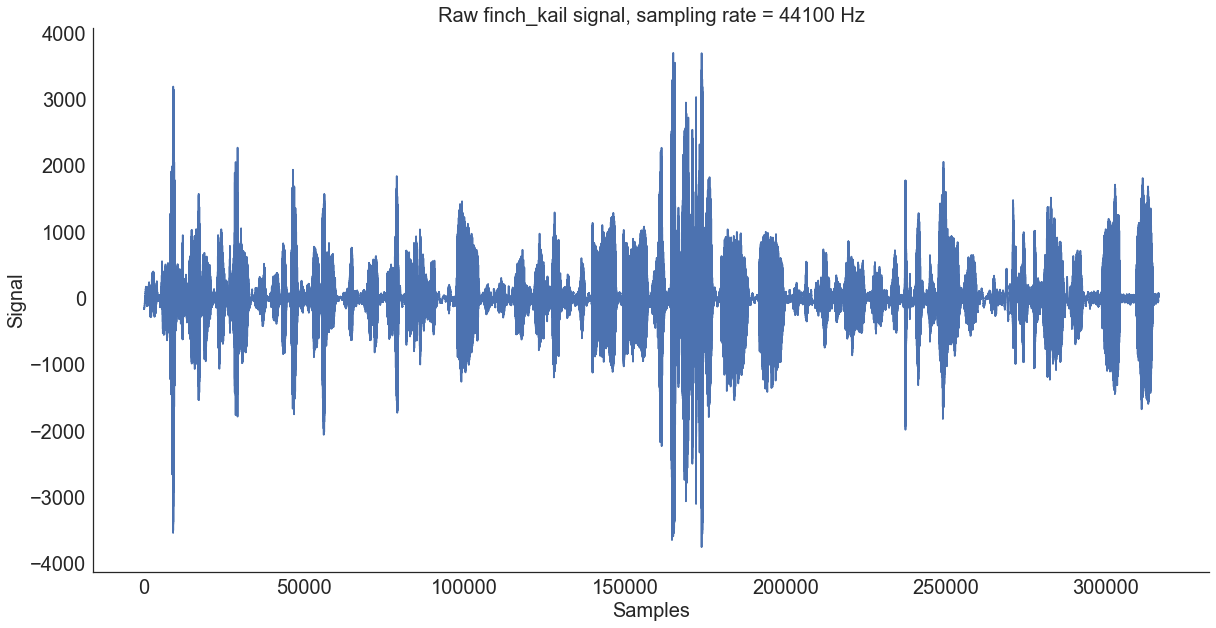

In [8]:
type = 'finch_kail'
with sns.axes_style('white'):
    plt.figure(figsize=(20, 10))
    sound_combined, fs = read_song_file(type)
    nsamples = len(sound_combined)
    sound_len_secs = nsamples / fs
    plt.plot(sound_combined)
    plt.xlabel('Samples', fontsize=20)
    plt.ylabel('Signal', fontsize=20)
    plt.title('Raw %s signal, sampling rate = %d Hz' % (type, fs), fontsize=20);
    sns.despine()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
filename = 'waveform_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [137]:
scipy.io.wavfile.write('./Finch_songs/finch_tutors_all.wav', fs, sound_combined)

In [9]:
#p=TW determines spatial and temporal resolution
#k runs from 1,2,...2p-1, are the orthogonal modes which serve as 'samples' of the fft
def my_spectrogram(x):
    '''TODO: Implement multitapering with multiple dpss functions'''
    start = 0
    seg = sound_combined[start:start+nperseg]
    np.fft.fft(seg * window).shape

def multitaper_spec(X, fs, nadvance=100, slepian_len=500, nperseg=4096*4, NW=1):
    '''Perform a dpss multitapering
    Returns the spectrogram, frequency (f) and time ticks (t)'''

    # Use slepian window of width 0.3
    #window = scipy.signal.slepian(M=slepian_len, width=NW / slepian_len)
    window = scipy.signal.blackman(slepian_len)
    window = np.lib.pad(window, (0, nperseg - slepian_len), 'constant', constant_values=(0, 0))
    noverlap = len(window) - nadvance

    f,t,spectrogram = scipy.signal.spectrogram(X, fs, window=window, noverlap=noverlap)
    spectrogram = 20 * np.log10(spectrogram) #Units: dB
    
    return (f, t, spectrogram)

def sample_logspec(spectrogram, f, nsamples=256, fmin=100.0, fmax=4000.0):
    '''Sample the spectrogram to collect the required number of samples
    in frequency from fmin to fmax, logarithmically spaced
    Returns the spectrogram and the frequencies sampled'''
    # Frequencies to sample
    spacing = (np.log(fmax) - np.log(fmin)) / (nsamples - 1)
    logfreqs = np.log(fmin) + np.arange(nsamples) * spacing
    freqs = np.exp(logfreqs)
    
    # Sampled version
    row_ids = []
    for freq in freqs:
        row_ids.append(len(f[f < freq]))

    logspec = spectrogram[row_ids,:]
    return (logspec, freqs)

def format_func_spec(value, tick_number):
    '''Format tick marks for spectrogram plot'''
    if value >= len(freqs):
        label = max(freqs)
    else:
        label = freqs[int(value)]
    return int(np.round(label, -2))

def format_func_pcs(value, tick_number):
    '''Formatting axis ticks for the PC plot'''
    return value

In [10]:
nadvance = 100
#n_perseg = 4096*4
#n_slep = 600

In [50]:
# For multiple learning stages
n_comp_pca = 200
nfiles_per_batch = 20
n_batch = 10

# Set learning parameters
iters_s = 5 #number of iterations per s or A update
iters_A = 80
n_neurons = 150 #number of neurons
lamb = 0.5 #weight of sparsity constraint
tau = 0.1 #changed 0.1 to 0.01 10/1 #learning rate for s update
eta = 0.01
#learning rate for A update
theta = 0.001 #learning rate for A update (orthogonalizing component)
nreps = 100

# Initialize and normalize A
A = np.random.rand(comp.shape[0], n_neurons)
A /= np.linalg.norm(A, axis=0)
np.seterr(invalid='raise')
best_cost_s = np.inf
best_cost_A = np.inf
prev_cost_s = np.inf
prev_cost_A = np.inf
eta_ori = eta

#TODO: PCA should be consistent

for i in range(n_batch):
    print('####Starting iteration', i, '...')
    tstart = i * nfiles_per_batch
    tend = (i + 1) * nfiles_per_batch
    fs, f, t, spectrogram = make_spectrogram_multifile('pda', tstart, tend, 
                            nadvance=nadvance, nperseg=n_perseg, slepian_len=n_slep)
    spectrogram, logfreqs = sample_logspec(spectrogram, f, fmin=100.0, fmax=4000)
    
    segment_width = spectrogram.shape[0]
    segment_step = int(segment_len / 5) #samples
    dt = segment_len * nadvance / fs * 1000 #length of each window in ms
    segments_lst = []
    for t_start in np.arange(0, spectrogram.shape[1] - segment_len, segment_step):
        segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])

    print('    Doing pca...')
    # Do pca on each segment
    X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
    for idx, segment in enumerate(segments_lst):
        X[:,idx] = segment.ravel()    

    # Mean subtract
    Xmean = np.mean(X, axis=1)
    Xmeans = np.tile(Xmean, (X.shape[1], 1))
    X1 = X - Xmeans.T

    # Perform pca with whitening
    pca = PCA(n_components=n_comp_pca, whiten=True)
    pca.fit(X1.T)
    Y = pca.transform(X1.T).T 
    print('        Number of segments:', Y.shape[1])
    
    # Start learning
    for i in range(nreps):
        if i == 0:
            A = best_A
        print('    **** Finding s, iteration ', i, '####')
        s,cost_s = find_s_batch(tau, A, Y, lamb, niter=iters_s, verbose=False)
        print('    **** Finding A, iteration ', i, '####')

        try:
            A,cost_A = do_multiple_learn_steps(Y, A, s, eta=eta, theta=theta, nsteps=iters_A, verbose=False)
            #if eta != eta_ori:
            #    eta = eta_ori
        except FloatingPointError: #Catch warning: invalid value encountered in subtract
            print('Warning raised, decreasing eta')
            eta *= 0.1
        A /= np.linalg.norm(A, axis=0)

        print('        (tau, eta, theta) = ', tau, eta, theta)
        prev_cost_s = cost_s
        prev_cost_A = cost_A

        if i > 0 and cost_A < best_cost_A:
            best_cost_s = cost_s
            best_cost_A = cost_A
            best_s = s
            best_A = A

####Starting iteration 0 ...
Reading file 0  of  20
Reading file 1  of  20
Reading file 2  of  20
Reading file 3  of  20
Reading file 4  of  20
Reading file 5  of  20
Reading file 6  of  20
Reading file 7  of  20
Reading file 8  of  20
Reading file 9  of  20
Reading file 10  of  20
Reading file 11  of  20
Reading file 12  of  20
Reading file 13  of  20
Reading file 14  of  20
Reading file 15  of  20
Reading file 16  of  20
Reading file 17  of  20
Reading file 18  of  20
Reading file 19  of  20
    Doing pca...
        Number of segments: 3575
    **** Finding s, iteration  0 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  287497.089495
    **** Finding A, iteration  0 ####
Warning raised, decreasing eta
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  1 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration

Best cost =  109729.865728
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  25 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  223845.987054
    **** Finding A, iteration  25 ####
Best cost =  109544.059827
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  26 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  223625.882062
    **** Finding A, iteration  26 ####
Best cost =  109395.934445
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  27 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  223460.997661
    **** Finding A, iteration  27 ####
Best cost =  109236.334646
        (tau, eta, theta) =  0.1 0.00

Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  221283.811458
    **** Finding A, iteration  51 ####
Best cost =  107102.100921
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  52 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  221228.41921
    **** Finding A, iteration  52 ####
Best cost =  107044.748564
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  53 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  221202.984514
    **** Finding A, iteration  53 ####
Best cost =  107028.966284
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  54 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting it

Best cost =  220656.245935
    **** Finding A, iteration  77 ####
Best cost =  106362.773841
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  78 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  220633.166821
    **** Finding A, iteration  78 ####
Best cost =  106327.808258
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  79 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  220624.344433
    **** Finding A, iteration  79 ####
Best cost =  106325.430661
        (tau, eta, theta) =  0.1 0.001 0.001
    **** Finding s, iteration  80 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  220628.678438
    **** Finding A, iteration  80 ###

KeyboardInterrupt: 

In [54]:
fs, f, t, spectrogram = make_spectrogram_multifile('pda', 0, 40, nadvance=nadvance, nperseg=n_perseg, slepian_len=n_slep)
logspec, freqs = sample_logspec(spectrogram, f, fmin=100.0, fmax=4000)


Reading file 0  of  40
Reading file 1  of  40
Reading file 2  of  40
Reading file 3  of  40
Reading file 4  of  40
Reading file 5  of  40
Reading file 6  of  40
Reading file 7  of  40
Reading file 8  of  40
Reading file 9  of  40
Reading file 10  of  40
Reading file 11  of  40
Reading file 12  of  40
Reading file 13  of  40
Reading file 14  of  40
Reading file 15  of  40
Reading file 16  of  40
Reading file 17  of  40
Reading file 18  of  40
Reading file 19  of  40
Reading file 20  of  40
Reading file 21  of  40
Reading file 22  of  40
Reading file 23  of  40
Reading file 24  of  40
Reading file 25  of  40
Reading file 26  of  40
Reading file 27  of  40
Reading file 28  of  40
Reading file 29  of  40
Reading file 30  of  40
Reading file 31  of  40
Reading file 32  of  40
Reading file 33  of  40
Reading file 34  of  40
Reading file 35  of  40
Reading file 36  of  40
Reading file 37  of  40
Reading file 38  of  40
Reading file 39  of  40


In [107]:
t

array([ 0.18575964,  0.18802721,  0.19029478, ...,  6.98394558,
        6.98621315,  6.98848073])

In [11]:
# Compute the spectrogram and log spectrogram
f,t,spectrogram = multitaper_spec(sound_combined, fs=fs, nadvance=nadvance)
logspec, freqs = sample_logspec(spectrogram, f, fmin=300.0, fmax=15000)

Error: file exists. Skipped writing


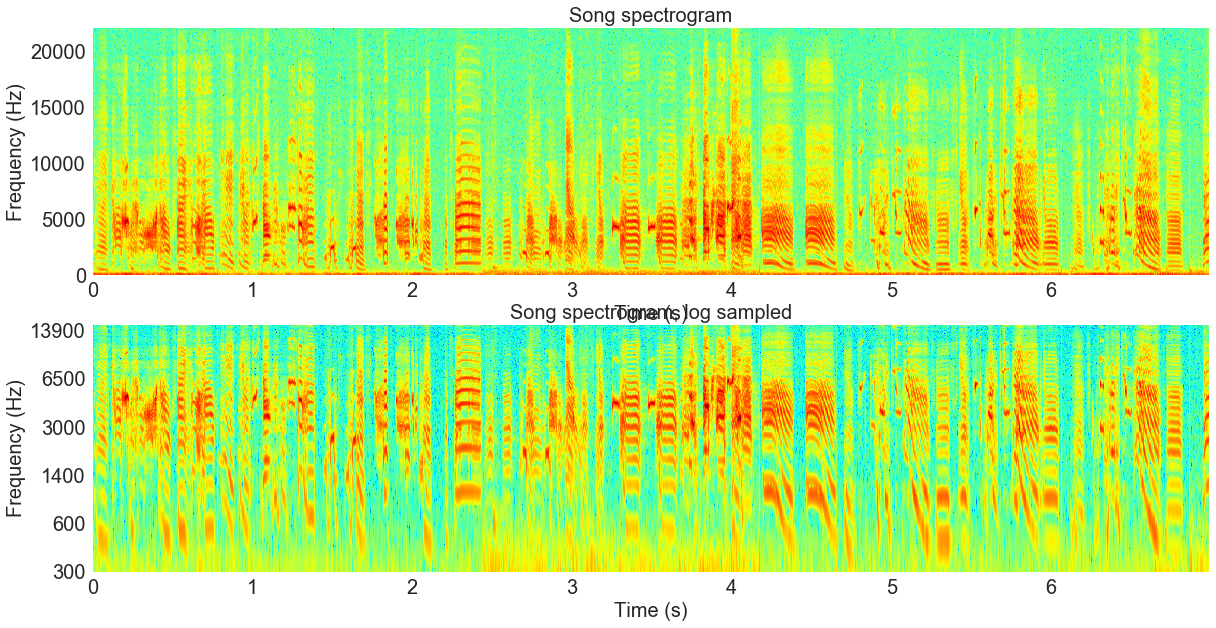

In [12]:
# Time and frequency ranges for plotting
fmin = 0
fmax = np.max(f) #Hz
tmin = 0
tmax = max(t) #s
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (s)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

# For plotting
ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

filename = 'spectrogram_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Segment the sound and perform PCA

In [13]:
# Segment into overlapping segments
spectrogram = logspec
segment_len_ms = 50
segment_len = int(segment_len_ms / 1000 / nadvance * fs) #samples

n_comp_pca = 200
segment_width = spectrogram.shape[0]
segment_step = int(segment_len / 10) #samples
dt = segment_len * nadvance / fs * 1000 #length of each window in ms
segments_lst = []
for t_start in np.arange(0, spectrogram.shape[1] - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()    

# Mean subtract
Xmean = np.mean(X, axis=1)
Xmeans = np.tile(Xmean, (X.shape[1], 1))
X1 = X - Xmeans.T

# Perform pca with whitening
pca = PCA(n_components=n_comp_pca, whiten=True)
pca.fit(X1.T)
Y = pca.transform(X1.T).T 

print('Number of segments:', Y.shape[1])

Number of segments: 1490


Error: file exists. Skipped writing


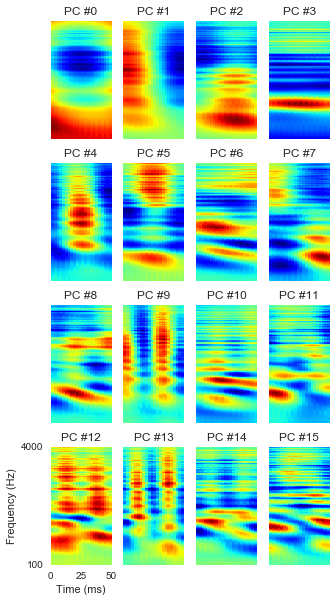

In [14]:
# Visualize principal components
n_show = 4 #number of rows to show. will show n_show x n_show pca components
fig, ax = plt.subplots(n_show, n_show, figsize=(5,10))
comp = pca.components_

for i in range(n_show):
    for j in range(n_show):
        idx = n_show*i + j
        component = comp[idx,:].reshape((segment_width, segment_len))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        ax[i][j].set_title('PC #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs))

filename = 'PCs_finch_kail_171009.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Learning the sparse representation

In [15]:
# Set learning parameters
iters_s = 5 #number of iterations per s or A update
iters_A = 80
n_neurons = 150 #number of neurons
lamb = 0.5 #weight of sparsity constraint
tau = 0.1 #changed 0.1 to 0.01 10/1 #learning rate for s update
eta = 0.1
#learning rate for A update
theta = 0.001 #learning rate for A update (orthogonalizing component)
nreps = 10

In [16]:
# For log keeping
filename = './Logs/171011_finch_kail.txt'
file = open(filename, 'w')
file.write('iters_s = %d, iters_A = %d, nreps = %d\n' % (iters_s, iters_A, n_neurons))
file.write('n_neurons = %d, n_pca_comp = %d\n' % (n_neurons, n_comp_pca))
file.write('lamb = %f, tau = %f, eta = %f, theta = %f\n' % (lamb, tau, eta, theta))

comment = ''
file.write('Comments: %s\n' % comment)

11

In [17]:
# Initialize and normalize A
A = np.random.rand(comp.shape[0], n_neurons)
A /= np.linalg.norm(A, axis=0)
np.seterr(invalid='raise')
best_cost_s = np.inf
best_cost_A = np.inf
prev_cost_s = np.inf
prev_cost_A = np.inf
eta_ori = eta

In [18]:
for i in range(nreps):
    print('#### Finding s, iteration ', i, '####')
    s,cost_s = find_s_batch(tau, A, Y, lamb, niter=iters_s, verbose=False)
    print('#### Finding A, iteration ', i, '####')
    
    try:
        A,cost_A = do_multiple_learn_steps(Y, A, s, eta=eta, theta=theta, nsteps=iters_A, verbose=False)
        #if eta != eta_ori:
        #    eta = eta_ori
    except FloatingPointError: #Catch warning: invalid value encountered in subtract
        print('Warning raised, decreasing eta')
        eta *= 0.1
        
    A /= np.linalg.norm(A, axis=0)
    
    if cost_s <= prev_cost_s:
        tau *= 1.0
    else:
        tau *= 1.0
    
    if cost_A == prev_cost_A:
        eta *= 1.0
        theta *= 1.0
    else:
        eta *= 1.0
        theta *= 1.0
    
    print('(tau, eta, theta) = ', tau, eta, theta)
    #file.write('Iteration # %d. Best cost s = %f. Best cost A = %f\n' % (i, cost_s, cost_A))
    #file.write('tau = %f, eta = %f, theta = %f\n' % (tau, eta, theta))
    
    
    prev_cost_s = cost_s
    prev_cost_A = cost_A
        
    if i > 0 and cost_A < best_cost_A:
        best_cost_s = cost_s
        best_cost_A = cost_A
        best_s = s
        best_A = A
#file.write('Overall best cost A is %f\n' % best_cost_A)
file.close()

#### Finding s, iteration  0 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  148343.504606
#### Finding A, iteration  0 ####
Best cost =  135666.316614
(tau, eta, theta) =  0.1 0.1 0.001
#### Finding s, iteration  1 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  133374.935566
#### Finding A, iteration  1 ####
Warning raised, decreasing eta
(tau, eta, theta) =  0.1 0.010000000000000002 0.001
#### Finding s, iteration  2 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Best cost =  133374.935566
#### Finding A, iteration  2 ####
Best cost =  101992.802947
(tau, eta, theta) =  0.1 0.010000000000000002 0.001
#### Finding s, iteration  3 ####
Starting iteration # 0 ...
Starting iteration # 1 ..

In [19]:
s,cost_s = find_s_batch(tau, best_A, Y, lamb, niter=20, verbose=True)

Starting iteration # 0 ...
Cost =  145927.733103 . tau = 0.10500000000000001
Starting iteration # 1 ...
Cost =  138771.012975 . tau = 0.11025000000000001
Starting iteration # 2 ...
Cost =  131646.626457 . tau = 0.11576250000000002
Starting iteration # 3 ...
Cost =  125230.337326 . tau = 0.12155062500000002
Starting iteration # 4 ...
Cost =  119816.391354 . tau = 0.12762815625000004
Starting iteration # 5 ...
Cost =  115396.411191 . tau = 0.13400956406250006
Starting iteration # 6 ...
Cost =  111815.680102 . tau = 0.14071004226562506
Starting iteration # 7 ...
Cost =  108901.19684 . tau = 0.14774554437890633
Starting iteration # 8 ...
Cost =  106529.425179 . tau = 0.15513282159785166
Starting iteration # 9 ...
Cost =  104605.27443 . tau = 0.16288946267774426
Starting iteration # 10 ...
Cost =  103079.395613 . tau = 0.17103393581163148
Starting iteration # 11 ...
Cost =  101856.245095 . tau = 0.17958563260221305
Starting iteration # 12 ...
Cost =  100885.504052 . tau = 0.1885649142323237

Error: file exists. Skipped writing


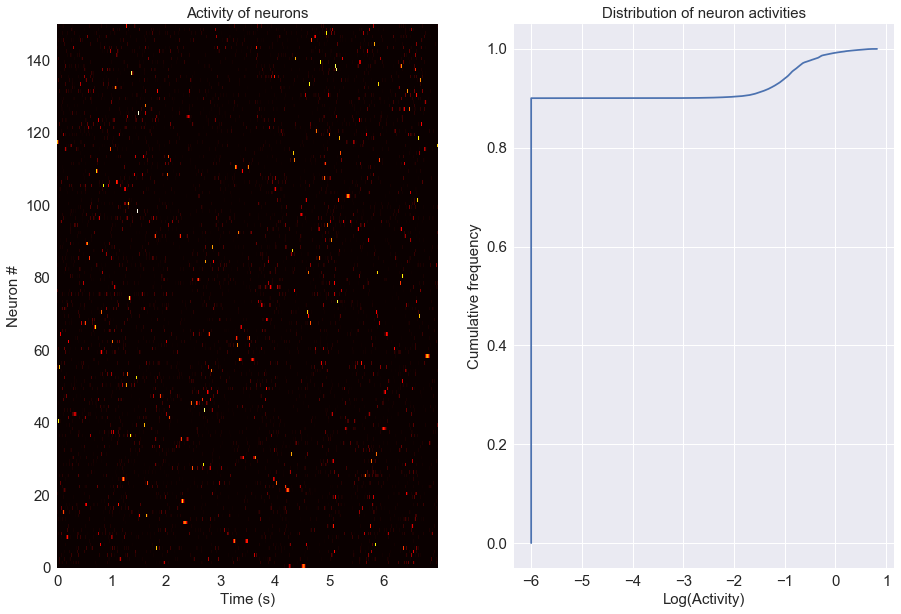

In [20]:
# Visualize the activities of neurons
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sound_len_secs = max(t)

ax[0].imshow(best_s, cmap='hot', extent=[0, sound_len_secs, 0, n_neurons], aspect='auto')
#fig.colorbar(ax[0])
ax[0].set_xlabel('Time (s)', fontsize=15)
ax[0].set_ylabel('Neuron #', fontsize=15)
ax[0].grid(False)
ax[0].set_title('Activity of neurons', fontsize=15);
ax[0].tick_params(axis='both', which='major', labelsize=15)

#ax[0].xticks(fontsize=15)
#ax[0].yticks(fontsize=15);

s_activities = best_s.ravel()
ax[1].plot(np.sort(np.log10(s_activities + 10**-6)), np.arange(len(s_activities)) / len(s_activities))
ax[1].set_xlabel('Log(Activity)', fontsize=15)
ax[1].set_ylabel('Cumulative frequency', fontsize=15)
ax[1].set_title('Distribution of neuron activities', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)



filename = 'neurons_activity_finch_kail_171007_200pcs_150neurons.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Reconstruction of the spectrogram

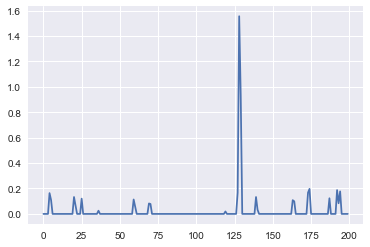

In [21]:
plt.plot(best_s[0,:200])

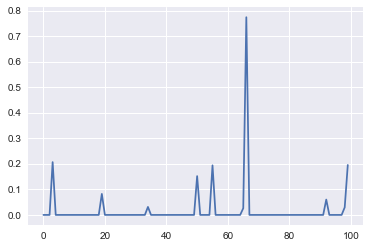

In [72]:
plt.plot(best_s[1,:100])

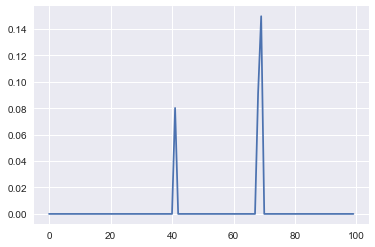

In [73]:
plt.plot(best_s[2,:100])

In [22]:
def reconstruct_from_A_s(A, S, pca, shape, segment_width, segment_len, Y=None):
    '''Reconstruct the spectrogram, given a dictionary A of receptive fields,
    and s: the activity of neurons'''
    Y = np.dot(A, S)
    Y_inverted = pca.inverse_transform(Y.T).T
    recons = np.zeros(shape)

    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

def reconstruct_from_pca(Y, pca, shape, segment_width, segment_len):
    '''Reconstruct the spectrogram, given its pca projection'''
    recons = np.zeros(shape)
    Y_inverted = pca.inverse_transform(Y.T).T
    #Y_inverted = np.dot(comp.T, Y)
    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

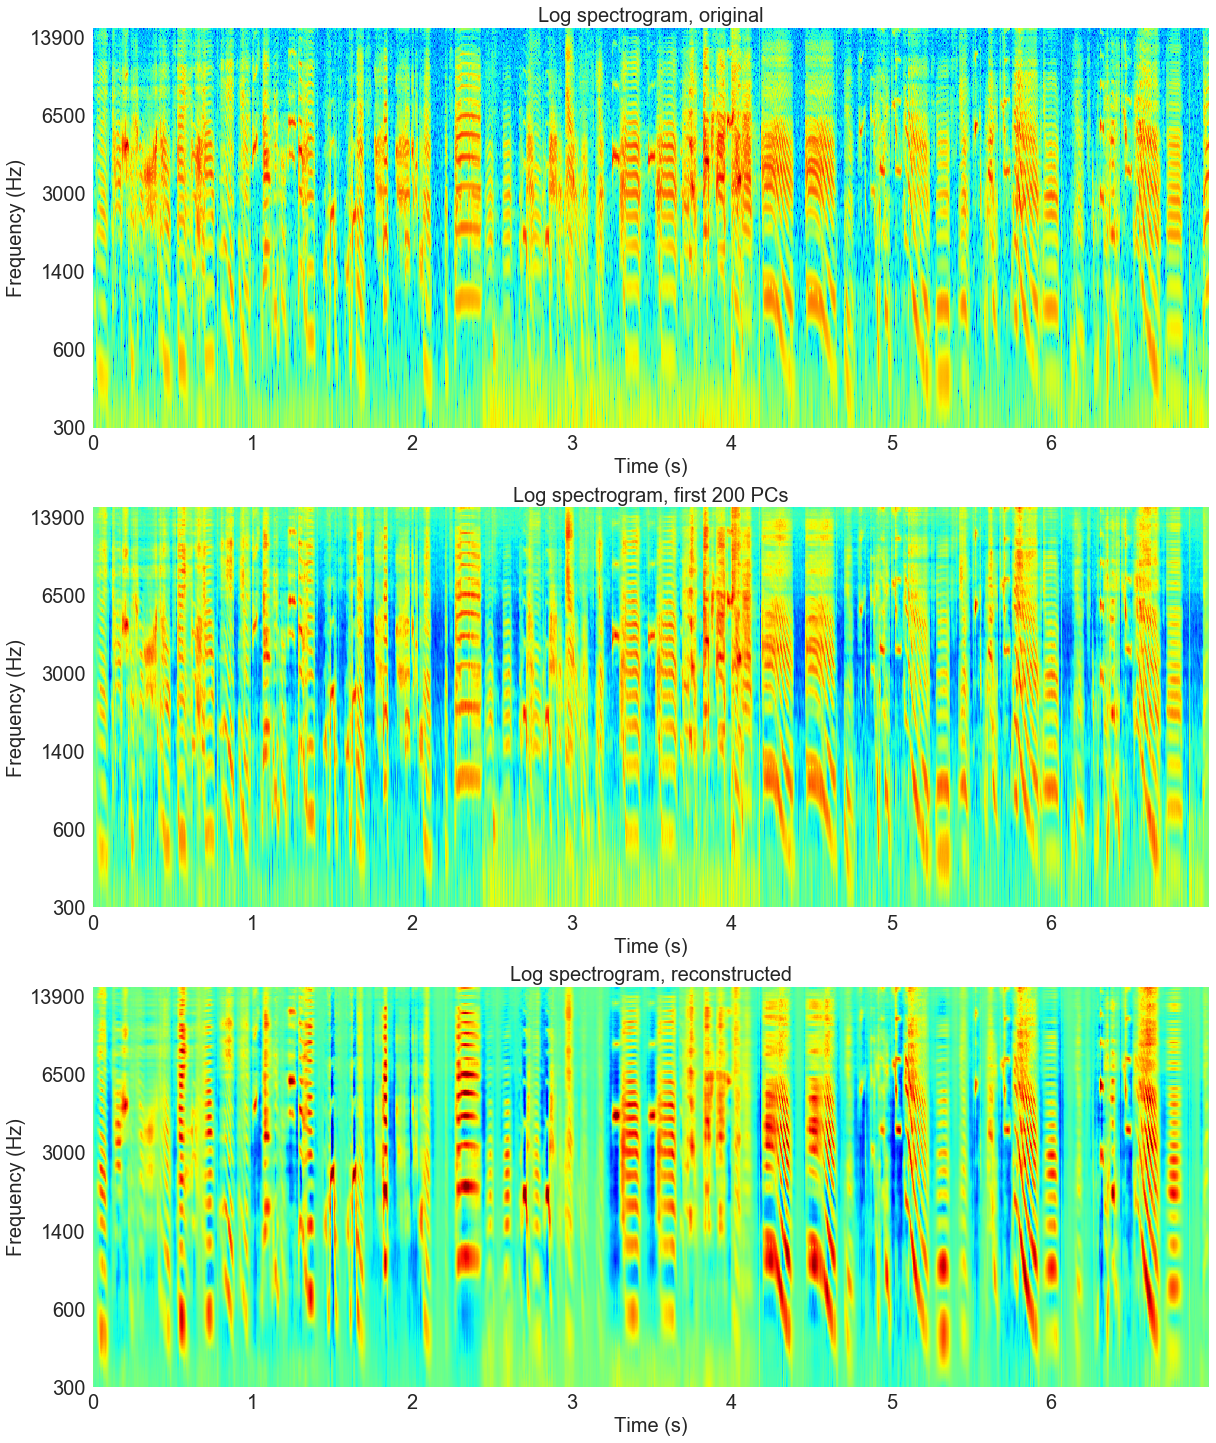

In [37]:
recons = reconstruct_from_A_s(best_A, best_s, pca, spectrogram.shape, segment_width, segment_len)
recons_pca = reconstruct_from_pca(Y, pca, spectrogram.shape, segment_width, segment_len)

# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = max(t) #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax])

spectrogram_n = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)
recons_n = (recons - np.mean(recons)) / np.std(recons)
recons_pca_n = (recons_pca - np.mean(recons_pca)) / np.std(recons_pca)

# For plotting
fig, ax = plt.subplots(3, 1, figsize=(20,25))
ax[0].imshow(np.flipud(spectrogram_n[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)], vmin=-4, vmax=4)
ax[0].grid(False)
ax[0].set_title('Log spectrogram, original', fontsize=20)
ax[0].set_xlabel('Time (s)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[0].tick_params(axis='both', which='major', labelsize=20)



ax[1].imshow(np.flipud(recons_pca_n[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)], vmin=-4, vmax=4)
ax[1].grid(False)
ax[1].set_title('Log spectrogram, first 200 PCs', fontsize=20)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

# Plot the original vs the reconstructed songs
ax[2].imshow(np.flipud(recons_n[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)], vmin=-4, vmax=4)
ax[2].grid(False)
ax[2].set_title('Log spectrogram, reconstructed', fontsize=20)
ax[2].set_xlabel('Time (s)', fontsize=20)
ax[2].set_ylabel('Frequency (Hz)', fontsize=20);
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[2].tick_params(axis='both', which='major', labelsize=20)



filename = 'recons_comparison_finch_kail_171010_200pcs_150neurons.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')
    

## Visualize the receptive fields of the neurons

Error: file exists. Skipped writing


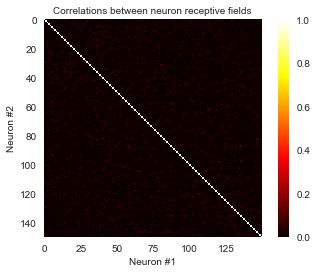

In [23]:
# Check the orthogonality of neurons
A_inv = np.dot(comp.T, best_A)
corr = np.dot(A_inv.T, A_inv)
plt.imshow(corr, cmap='hot')
plt.grid(False)
plt.colorbar()
plt.clim(0, 1)
plt.title('Correlations between neuron receptive fields', fontsize=10)
plt.xlabel('Neuron #1', fontsize=10)
plt.ylabel('Neuron #2', fontsize=10)

filename = 'correlations_human_171005.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [ ]:
plt.imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
plt.colorbar()

In [ ]:
c1 = A[:,0]
c1_inv = pca.inverse_transform(c1)

In [ ]:
c1_im = np.reshape(c1_inv, (segment_width, segment_len))
plt.imshow(np.flipud(c1_im), cmap='jet')
plt.colorbar()

Error: file exists. Skipped writing


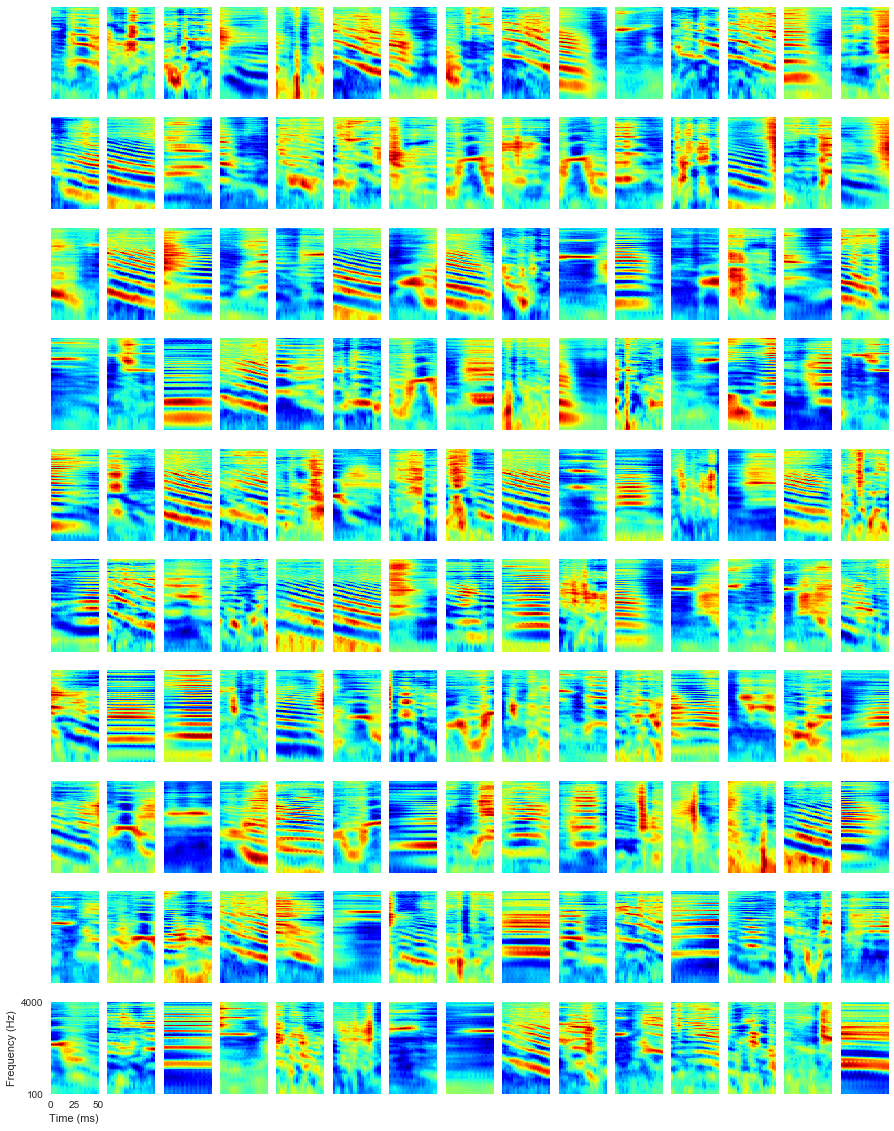

In [28]:
nrows = 10
ncols = 15
A_inverted = pca.inverse_transform(best_A.T).T
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols,2 * nrows))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
strfs_all = []


for i in range(nrows):
    for j in range(ncols):
        A_col = best_A[:,ncols*i + j]
        A_col_inv = pca.inverse_transform(A_col)
        A_inv_im = np.reshape(A_col_inv, (segment_width, segment_len))
        #seg = A_inverted[:,n_show*i + j].reshape((segment_width, segment_len))
        A_inv_im /= np.max(np.abs(A_inv_im))
        
        # Invert if skew is negative
        skew = scipy.stats.skew(A_inv_im.ravel())
        if skew < 0:
            A_inv_im *= -1
        
        # Filter
        selem = skimage.morphology.disk(2)

        #filt = skimage.filters.rank.mean_percentile(A_inv_im, selem=selem, p0=.1, p1=.9)
        #filt = skimage.filters.rank.mean_bilateral(A_inv_im, selem=selem, s0=500, s1=500)
        #filt = skimage.filters.rank.mean(A_inv_im, selem=selem)
        #filt = filt / np.max(np.abs(filt))
        #filt = scipy.ndimage.filters.median_filter(A_inv_im, size=5)
        #filt = scipy.ndimage.filters.gaussian_filter(filt, sigma=2)
        filt = A_inv_im        
        
        idx = n_show*i + j
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].c
        #ax[i][j].set_yscale('log')
        #ax[i][j].set_title('Neuron #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != nrows - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 
filename = 'receptive_fields_finch_kail_171009_200pcs_150neurons.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Export the receptive fields and PCA into a file

In [41]:
df = pd.DataFrame(best_A)
df.to_csv("./STRFs/STRF_finch_kail_150_neurons_171010.csv", header=None)

In [43]:
f = open('pca_finch_kail_150neurons_200pcs.pckl', 'wb')
pickle.dump(pca, f)
f.close()

In [44]:
A_inv_im.shape

(256, 22)

In [46]:
spectrogram.shape

(256, 3001)

In [41]:
# For saving of strfs
strfs_all = []

for i in range(best_A.shape[1]):
    A_col = best_A[:,i]
    A_col_inv = pca.inverse_transform(A_col)
    A_inv_im = np.reshape(A_col_inv, (segment_width, segment_len))
    A_inv_im /= np.max(np.abs(A_inv_im))

    # Invert if skew is negative
    skew = scipy.stats.skew(A_inv_im.ravel())
    if skew < 0:
        A_inv_im *= -1
    
    strfs_all.append(A_inv_im.ravel())

strfs_arr = np.vstack(strfs_all).T
strfs_df = pd.DataFrame(strfs_all)
strfs_df.to_csv("./STRFs/STRFarr_finch_kail_150_neurons_171010.csv", header=None, index_label=False)

In [43]:
strfs_df

0         1         2         3         4         5         6     \
0   -0.041519 -0.093645 -0.175332 -0.103996  0.001758 -0.014648  0.018012   
1    0.059778  0.105284  0.146193  0.032315 -0.059680  0.080085  0.176906   
2   -0.459069 -0.437329 -0.302410 -0.230841 -0.227652  0.000188 -0.034450   
3   -0.041253 -0.005227  0.000266 -0.004804 -0.009617 -0.056467 -0.062959   
4    0.143921 -0.012019 -0.106834 -0.078383 -0.041656 -0.015396 -0.016657   
5   -0.123173 -0.098623 -0.046247 -0.032952 -0.133346 -0.336052 -0.286900   
6    0.276743  0.263352  0.310450  0.266746  0.163298  0.184991  0.197299   
7   -0.171408 -0.176485 -0.206291 -0.183620 -0.169192 -0.222094 -0.248351   
8   -0.023555  0.033981 -0.002239  0.072908 -0.003006 -0.017612 -0.142425   
9   -0.095695 -0.186905 -0.146117 -0.085303 -0.012823 -0.024798 -0.011693   
10  -0.125811 -0.084403 -0.149445 -0.116567 -0.111675 -0.095539 -0.149878   
11  -0.022833  0.044092 -0.054330 -0.098527 -0.069248 -0.193478 -0.199539   
12  -0.074869 -0.040872 -0.211628 -0.174341 -0.155295  0.087624  0.066189   
13  -0.033451 -0.026030 -0.022735 -0.050723 -0.021061  0.051172  0.085573   
14   0.307466  0.215552  0.317407  0.218685  0.219549  0.211256  0.245372   
15  -0.153522 -0.104096 -0.069668 -0.093984 -0.082400 -0.114684 -0.265889   
16   0.126005  0.176049  0.201683  0.155121 -0.005455  0.039204  0.007868   
17  -0.068498 -0.103913 -0.056884 -0.084022 -0.015097 -0.064243 -0.068623   
18  -0.164257 -0.133706 -0.105370 -0.102709 -0.008325 -0.058764 -0.034570   
19  -0.126604 -0.221073 -0.171809 -0.199375 -0.142398 -0.081454 -0.228312   
20  -0.425161 -0.355003 -0.261528 -0.116503 -0.074343 -0.239436 -0.042049   
21  -0.186078 -0.256193 -0.081927 -0.122083 -0.056481 -0.072992 -0.106631   
22  -0.050982 -0.019010 -0.130211  0.020121 -0.176246 -0.161703 -0.214323   
23   0.155581  0.020484 -0.046217  0.058729 -0.076138 -0.069675 -0.056748   
24  -0.189549 -0.104836 -0.167624 -0.244500 -0.046187 -0.106104  0.048120   
25  -0.239574 -0.207810 -0.137344 -0.117298 -0.118115 -0.165427 -0.174163   
26   0.099936 -0.123797 -0.182079 -0.040516  0.160651  0.240812  0.295205   
27   0.096073  0.099416  0.008239  0.093970  0.126340  0.070142  0.045208   
28   0.087091 -0.107646 -0.016663 -0.075201 -0.198693 -0.159288 -0.034688   
29  -0.064136 -0.112762 -0.189974 -0.212986 -0.194975 -0.168911 -0.121804   
..        ...       ...       ...       ...       ...       ...       ...   
120 -0.047618 -0.026098  0.041358  0.018311 -0.192127 -0.170284 -0.303901   
121  0.276184  0.204558  0.177603  0.113199  0.099765  0.048965  0.093260   
122  0.289981  0.250774  0.184240  0.208618  0.200991  0.308701  0.266826   
123 -0.133777 -0.230801 -0.158441 -0.099456 -0.107387 -0.012001 -0.092758   
124 -0.086764 -0.071173 -0.179468 -0.112940 -0.116265 -0.103753 -0.105847   
125 -0.010843 -0.007623 -0.016820 -0.015694  0.010615 -0.020021 -0.002032   
126 -0.371323 -0.374654 -0.306688 -0.254858 -0.181279 -0.174924 -0.298413   
127 -0.096108 -0.236443 -0.226052 -0.160659 -0.176717 -0.010814  0.122142   
128 -0.131001 -0.121363 -0.155226 -0.125838 -0.143248 -0.126771 -0.129317   
129 -0.086852 -0.002293 -0.092833 -0.099313 -0.172503 -0.140059 -0.125841   
130 -0.189740 -0.189723 -0.111866 -0.039153 -0.209906 -0.073539  0.016053   
131 -0.056787 -0.086335 -0.060441 -0.057129 -0.025779 -0.053848 -0.024783   
132 -0.001306  0.018750  0.067303  0.142390  0.189650  0.075872  0.050694   
133  0.392600  0.256838  0.282913  0.145703  0.024011  0.132355  0.167915   
134  0.085528  0.098033  0.029182  0.031588  0.018250  0.105678  0.011541   
135  0.025005  0.024375  0.029543 -0.035555 -0.025583 -0.046465 -0.061940   
136  0.155199  0.184214  0.219287  0.317311  0.369114  0.336362  0.225365   
137 -0.076399 -0.030730 -0.071135 -0.052866 -0.111264 -0.061327 -0.101686   
138 -0.134278 -0.207979 -0.169645 -0.186140 -0.071452 -0.035710 -0.001555   
139 -0.037277  0.052794  0.233789  0.168910 -0.004706 -0.072205 -0.030393   
140 -

In [40]:
strfs_df.to_csv?

## Convolution of STRFs with a song

In [44]:
# Read song
fs, song = scipy.io.wavfile.read('./Finch_songs/2017BBLB1_42968.51352408_8_21_14_15_52.wav')

In [108]:
def make_all_strfs(A, pca_used, segment_width, segment_len):
    '''Make the strf from a dictionary A's column given by index '''
    strfs_all = []
    for i in range(A.shape[1]):
        A_col = A[:,i]
        A_col_inv = pca_used.inverse_transform(A_col)
        A_inv_im = np.reshape(A_col_inv, (segment_width, segment_len))
        A_inv_im /= np.max(np.abs(A_inv_im))

        # Invert if skew is negative
        skew = scipy.stats.skew(A_inv_im.ravel())
        if skew < 0:
            A_inv_im *= -1
            
        strfs_all.append(A_inv_im)
    
    return strfs_all

In [109]:
strfs_all = make_all_strfs(best_A, pca, segment_width, segment_len)
# Compute the spectrogram and log spectrogram
f,t,spectrogram = multitaper_spec(song, fs=fs, nadvance=100, nperseg=4096*4)
logspec, freqs = sample_logspec(spectrogram, f, fmin=300.0, fmax=15000)

In [110]:
# Convolve
firings_all = []
logspec_centered = logspec - np.mean(logspec)
for strf in strfs_all:
    firing = scipy.signal.convolve2d(logspec_centered, strf, mode='valid').ravel()
    firings_all.append(firing)
firings_arr = np.vstack(firings_all)

In [111]:
strfs_all[0] - strfs_all[10]

array([[ 0.08429203, -0.00924162, -0.02588736, ...,  0.00956009,
        -0.07846405,  0.04832179],
       [ 0.08563744, -0.0128927 , -0.01926874, ...,  0.01818781,
        -0.08320615,  0.05515909],
       [ 0.08965891, -0.01512907, -0.01728175, ...,  0.02107137,
        -0.08630128,  0.05742398],
       ..., 
       [-0.06702781, -0.16643913, -0.13326423, ...,  0.53484757,
         0.41492737,  0.46764525],
       [-0.23263451, -0.30499951, -0.43216866, ...,  0.41124688,
         0.39660457,  0.3638675 ],
       [-0.19501235, -0.22786321, -0.22296209, ...,  0.27083442,
         0.16357614,  0.29009545]])

In [105]:
np.max(firings_arr[0,:] - firings_arr[1,:])

0.0

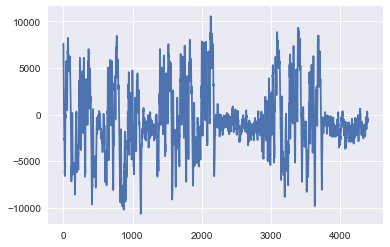

In [118]:
plt.plot(firings_arr[50,:])

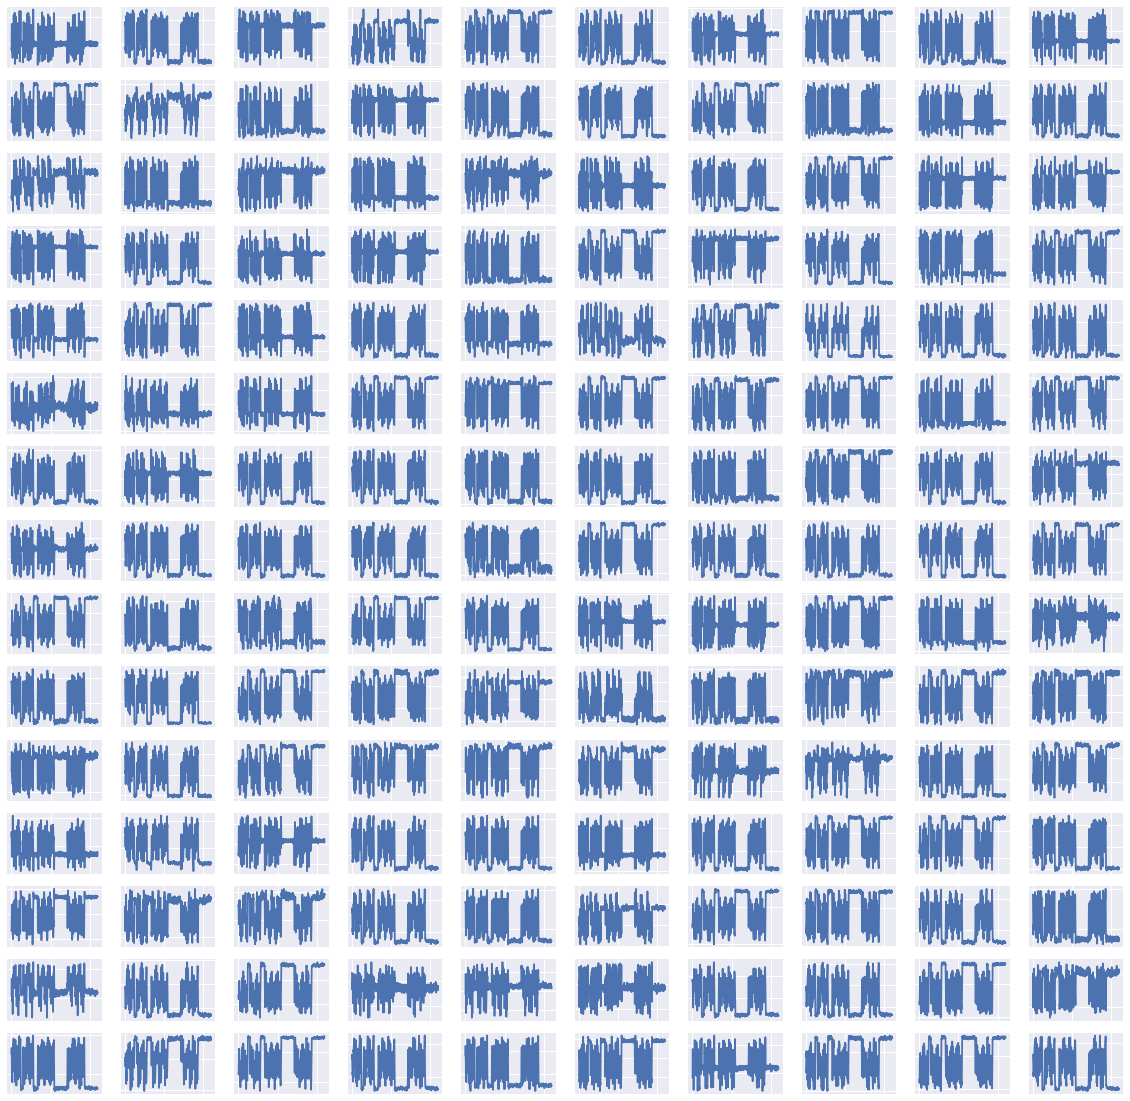

In [113]:
fig, ax = plt.subplots(15, 10, figsize=(20, 20))
for i in range(15):
    for j in range(10):
        ax[i][j].set(xticklabels=[], yticklabels=[])
        ax[i][j].plot(firings_arr[i * 10 + j,:]);